# Get Dunkin Donuts locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
import re
import numpy as np

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Get parsed json data from each of the the [state directory pages](https://locations.dunkindonuts.com/en)

In [4]:
state_abbreviations = [
    "al",
    # "ak",
    "az",
    "ar",
    "ca",
    "co",
    "ct",
    "de",
    "fl",
    "ga",
    "hi",
    # "id",
    "il",
    "in",
    "ia",
    "ks",
    "ky",
    "la",
    "me",
    "md",
    "ma",
    "mi",
    "mn",
    "ms",
    "mo",
    # "mt",
    "ne",
    "nv",
    "nh",
    "nj",
    "nm",
    "ny",
    "nc",
    # "nd",
    "oh",
    "ok",
    # "or",
    "pa",
    "ri",
    "sc",
    # "sd",
    "tn",
    "tx",
    "ut",
    "vt",
    "va",
    # "wa",
    "wv",
    "wi",
    "wy",
]

jsons_list = []

for s in tqdm(state_abbreviations):
    response = requests.get(f"https://locations.dunkindonuts.com/en/{s}")
    soup = BeautifulSoup(response.text, "html.parser")

    # Check if script tag is found
    script_tag = soup.find("script")
    if script_tag is not None:
        js_statement = script_tag.string

        # Extract JSON data using regular expression
        import re

        match = re.search(r"\{.*\}", js_statement)
        if match:
            json_data_str = match.group()
            try:
                json_data = json.loads(json_data_str)
                # print(f"Great Success! We got {s.upper()}!")
                jsons_list.append(json_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for {s}: {e}")
        else:
            print(f"")
    else:
        print(f"{s.upper()} is pain in my assholes. No JSON.")

  0%|          | 0/43 [00:00<?, ?it/s]

#### Grab json object for each state, append to list

In [5]:
dfs = []
for jl in jsons_list:
    df_jsons = pd.DataFrame(jl["document"]["dm_directoryChildren"]).explode(
        ["dm_directoryChildren"]
    )
    dfs.append(df_jsons)

#### Dataframe of state details

In [6]:
store_pages_df = pd.concat(dfs).reset_index(drop=True)

In [7]:
len(store_pages_df)

9538

#### Tidy up

In [8]:
store_pages_df["url"] = pd.json_normalize(store_pages_df["dm_directoryChildren"])

In [9]:
store_pages_df = store_pages_df.drop("dm_directoryChildren", axis=1).rename(
    columns={"dm_baseEntityCount": "count", "name": "city"}
)
store_pages_df["state"] = store_pages_df["slug"].str[3:5].str.upper()

In [10]:
store_pages_df["count"] = store_pages_df["count"].astype(int)

In [11]:
# store_pages_df = store_pages_df[store_pages_df["count"] == 1]
# stores_multiple = store_pages_df[store_pages_df["count"] >= 2]

In [12]:
store_pages_urls = list(store_pages_df["url"].unique())
# stores_multiple_urls = list(stores_multiple["url"].unique())

---

#### Extract json from individual location pages

In [13]:
locations_list = []

for st in tqdm(store_pages_urls):
    locations_response = requests.get("https://locations.dunkindonuts.com/" + st)
    locations_content = BeautifulSoup(locations_response.text, "html.parser")

    # Check if script tag is found
    locations_script_tag = locations_content.find("script")
    if locations_script_tag is not None:
        js_statement = locations_script_tag.string

        match = re.search(r"\{.*\}", js_statement)
        if match:
            locations_json_data_str = match.group()
            try:
                locations_json_data = json.loads(locations_json_data_str)
                # print(f"Great Success! We got {st.upper()}!")
                locations_list.append(locations_json_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for {st}: {e}")
        else:
            print(f"")
    else:
        print(f"{st.upper()} is pain in my assholes. No JSON.")

  0%|          | 0/9538 [00:00<?, ?it/s]

In [14]:
dfs_ll = []
for ll in locations_list:
    # ll_jsons = pd.DataFrame()
    dfs_ll.append(ll["document"])

In [15]:
location_dicts = []

for ll in locations_list:
    ll_dict = {
        "id": ll.get("document", {}).get("uid", ""),
        "address": ll.get("document", {}).get("address", {}).get("line1", ""),
        "address2": ll.get("document", {}).get("address", {}).get("line2", ""),
        "city": ll.get("document", {})
        .get("dm_directoryParents", [])[2]
        .get("name", ""),
        "state_abbr": ll.get("document", {}).get("address", {}).get("region", ""),
        "state": ll.get("document", {})
        .get("dm_directoryParents", [])[1]
        .get("name", ""),
        "zip": ll.get("document", {}).get("address", {}).get("postalCode", ""),
        "phone": ll.get("document", {}).get("mainPhone", ""),
        # "url": ll.get("document", {}).get("dm_directoryParents", [])[2].get("slug", ""),
        "latitude": ll.get("document", {})
        .get("geocodedCoordinate", {})
        .get("latitude", ""),
        "longitude": ll.get("document", {})
        .get("geocodedCoordinate", {})
        .get("longitude", ""),
    }
    location_dicts.append(ll_dict)

In [16]:
df = pd.DataFrame(location_dicts)

In [17]:
len(df)

9538

In [18]:
df.head()

,id,address,address2,city,state_abbr,state,zip,phone,latitude,longitude
0,17601460,1114 1st St N,Suite 200,Alabaster,AL,Alabama,35007,(205) 624-4880,33.256487,-86.812763
1,22287152,8171 US Highway 431,,Albertville,AL,Alabama,35950,(256) 869-6075,34.281106,-86.22043
2,12113227,1700 US Highway 72 E,,Athens,AL,Alabama,35611,(256) 960-9302,34.781337,-86.934901
3,12110626,2049 S College St,,Auburn,AL,Alabama,36832,(334) 501-2233,32.566051,-85.501599
4,17199810,171 N College St,,Auburn,AL,Alabama,36830,(334) 707-8552,32.608705,-85.482022


---

## Geography

#### GeoDataFrame from lon/lat

In [19]:
df_src = df.copy()

In [20]:
df_src["latitude"] = pd.to_numeric(df_src["latitude"], errors="coerce")
df_src["longitude"] = pd.to_numeric(df_src["longitude"], errors="coerce")

default_value = 0.0
df_src["latitude"] = df_src["latitude"].fillna(default_value)
df_src["longitude"] = df_src["longitude"].fillna(default_value)

In [21]:
gdf = gpd.GeoDataFrame(
    df_src, geometry=gpd.points_from_xy(df_src.longitude, df_src.latitude)
).set_crs("epsg:4326")

In [22]:
gdf = gdf[gdf["longitude"] != 0].copy()

<AxesSubplot: >

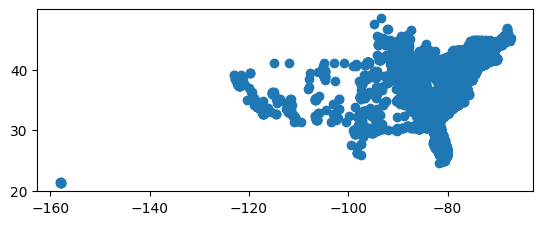

In [23]:
gdf.plot()

In [24]:
len(gdf)

9396

---

## Exports

#### CSV

In [25]:
df.to_csv("data/processed/dunkin_donuts_locations.csv", index=False)

#### JSON

In [26]:
df.to_json("data/processed/dunkin_donuts_.json", indent=4, orient="records")

#### GeoJSON

In [27]:
gdf.to_file("data/processed/dunkin_donuts_.geojson", driver="GeoJSON")